# [Module 2.2] AutoGluon Tabular 모델을 BYOC(Bring Your Own Container) 로 구현하기

아래 노트북은 Bring Your Own Container(BYOC)를 구현 했습니다.
**아래 공식 예제의 코드와 거의 유사하지만, 데이타는 다릅니다.** 여러분도 데이터만 교체하여 사용하실 수 있습니다.


- AutoGluon Bring Your Own Container (BYOC) 예제
    - https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/autogluon-tabular
- AutoGluon 공식 Lab Git 
    - [AutoGluon](https://github.com/awslabs/autogluon) 
    
이 노트북은 아래와 같은 작업을 합니다.
- 훈련 및 추론의 다커 이미지를 로컬에서 빌딩하고, ECR에 등록
- 훈련, 테스트 데이터 로딩 및 S3에 업로드
- 오토글로온 하이퍼 파라미터 설정
- 오토글루온 모델 훈련
    - 로컬 모드 및 세이지 메이커 호스트 모드 중 선택
- 세이지 메이커 모델 생성
- 배치 트랜스폼
- 실시간 엔드포인트 생성
- 추론

**편의상 원본의 영문으로 된 것을 그대로 사용하고, 필요시에 한글로 설명이 있습니다.** 

##### 이 노트북은 소요 시간이 약 30 분 걸립니다.

### 이 노트북은 SageMaker Studio에서는 Docker 부분에서 동작하지 않습니다. 
- SageMakere Studio Notebook 이 Docker 안에서 실행이 되기에, docker 명령어를 사용할 수 없습니다.
- SageMaker Studio 에서 다커 빌드를 위해서는 아래 URL을 참조 해주세요.
    - https://github.com/aws-samples/sagemaker-studio-image-build-cli

#### 다커에 익숙지 않으신 분은 아래를 확인 해주세요.
- Hello docker (for 데이터 과학자 및 개발자 by 강성문)
- https://github.com/mullue/hello-docker/blob/master/hello_docker.ipynb

## 커널 선택

세이지 메이커 노트북을 사용하신다면, 커널 "conda_mxnet_p36" 를 선택하세요.


아래는 [docker-compose](https://docs.docker.com/compose/) 를 확인해서 없으면 설치하는 shell 입니다. docker-compose는 로컬에서 다커를 정의하고 실행을 할 수 있는 편리한 환경을 제공합니다.

In [1]:
# Make sure docker compose is set up properly for local mode
!./setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


In [2]:
import os
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

# Account/s3 setup
session = sagemaker.Session()
local_session = local.LocalSession()
bucket = session.default_bucket()
prefix = 'sagemaker/autogluon-tabular'
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client(
    "sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region)
    )
account = client.get_caller_identity()['Account']

registry_uri_training = sagemaker.image_uris.retrieve('mxnet', region, version= '1.6.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='training')
registry_uri_inference = sagemaker.image_uris.retrieve('mxnet', region, version= '1.6.0', py_version='py3', instance_type='ml.m5.2xlarge', image_scope='inference')
ecr_uri_prefix = account +'.'+'.'.join(registry_uri_training.split('/')[0].split('.')[1:])

### 다커 이미지 로컬 빌딩 및 ECR 에 등록

훈련 및 추론은 위한 사용자 정의 다커 이미지를 로컬에서 빌딩하고, ECR에 등록합니다.
아래는 훈련과 추론의 다커 이미지 이름을 기술합니다.

In [3]:
training_algorithm_name = 'autogluon-sagemaker-training-pdt'
inference_algorithm_name = 'autogluon-sagemaker-inference-pdt'

In [37]:
print(f"account: {account}")
print(f"region: {region}")
print(f"ecr_uri_prefix: {ecr_uri_prefix}")
print(f"accouunt id having the mxnet built-in training image: \n{registry_uri_training.split('/')[0].split('.')[0]}")
print(f"the mxnet built-in training image: \n{registry_uri_training}")

account: 057716757052
region: ap-northeast-2
ecr_uri_prefix: 057716757052.dkr.ecr.ap-northeast-2.amazonaws.com
accouunt id having the mxnet built-in training image: 
763104351884
the mxnet built-in training image: 
763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/mxnet-training:1.6.0-cpu-py3


```build_push_training.sh``` 에 아래와 같은 파라미터를 제공 합니다.
```
account: 057716757052
region: ap-northeast-2
ecr_uri_prefix: 057716757052.dkr.ecr.ap-northeast-2.amazonaws.com
accouunt id having the mxnet built-in training image: 
763104351884
the mxnet built-in training image: 
763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/mxnet-training:1.6.0-cpu-py3
```
shell 파일은 아래와 같은 작업을 합니다.
- ECR에 위에서 명시한 알고리즘(에: autogluon-sagemaker-training-pdt) 의 리파지토리가 있는지 확인하고 없으면 생성 합니다.
- ECR의 알고리즘이 소유하고 있는 계정에 로그인합니다.
- ECR의 the mxnet built-in training image 를 가지고 있는 계정에 로그인 합니다.
- container-training/Dockerfile.training 의 Dockerfile 을 이용하여 다커 이미지를 로컬에서 빌딩합니다.
- 로컬에서 빌딩된 다커 이미지를 ECR에 등록(Push) 합니다.


```
!/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}
```
```
#!/bin/bash

# Get account
account=${1}

# Get the region defined in the current configuration
region=${2:-us-east-1}

# The name of our algorithm
algorithm_name=${3:-sagemaker-autogluon-training}

uri_prefix=${4}
fullname="${uri_prefix}/${algorithm_name}:latest"

# Get the registry id
registry_id=${5}
registry_uri=${6}

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --region ${region} --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
    aws ecr create-repository --region ${region} --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)
$(aws ecr get-login --registry-ids ${registry_id} --region ${region} --no-include-email)

# Build the docker image, tag with full name and then push it to ECR
docker build -t ${algorithm_name} -f container-training/Dockerfile.training . --build-arg REGISTRY_URI=${registry_uri}
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}
```

#### 아래는 훈련과 추론의 다커 이미지 생성 및 ECR 등록의 실제 명령어 입니다. 결과에 **에러** 가 없는지 확인을 꼭 하시기 바랍니다.

In [4]:
print("##### Build Training Image ###########")
!/bin/bash ./container-training/build_push_training.sh {account} {region} {training_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_training}
print("##### Build Inference Image ###########")
!/bin/bash ./container-inference/build_push_inference.sh {account} {region} {inference_algorithm_name} {ecr_uri_prefix} {registry_uri_training.split('/')[0].split('.')[0]} {registry_uri_inference}

##### Build Training Image ###########
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  153.4MB
Step 1/12 : ARG REGISTRY_URI
Step 2/12 : FROM ${REGISTRY_URI}
1.6.0-cpu-py3: Pulling from mxnet-training

b7cecaa5: Pulling fs layer 
7fa56252: Pulling fs layer 
af23a0f3: Pulling fs layer 
24de92ad: Pulling fs layer 
661cd1c8: Pulling fs layer 
0e745a6c: Pulling fs layer 
b831306f:

## 데이터 로딩

기존에 만든 데이터를 로딩하고 합니다. AutoGluon 이용시 별도의 검증(validation)셋의 생성은 필요하지 않습니다. (내부적으로 k-fold cross-validation을 이용합니다.)


In [38]:
%store -r no_auto_train_file
%store -r no_auto_test_file

train = pd.read_csv(no_auto_train_file)
test = pd.read_csv(no_auto_test_file)

# Split test X/y
label = 'classes'
y_test = test[label]
X_test = test.drop(columns=[label])
print("auto_train_file: ", train.shape)
print("auto_test_file: ", test.shape)



from IPython.display import display as dp
dp(train.head(2))
dp(test.head(2))
dp(X_test.head(2))




auto_train_file:  (53740, 18)
auto_test_file:  (13436, 18)


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


#### 훈련과 테스트 파일을 S3에 업로드

In [6]:
from p_utils import upload_s3

# Upload train. test file
data_prefix = 'autogluon/predict-deliver-time/data'

train_s3_path = upload_s3(bucket, no_auto_train_file, data_prefix)
test_s3_path = upload_s3(bucket, no_auto_test_file, data_prefix)
print("train_s3_path: ", train_s3_path)
print("test_s3_path: ", test_s3_path)

train_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/train/train.csv
test_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/test/test.csv


## 하이퍼 파라미터를 설정 
실제 훈련을 하기 전에 훈련 이미지에 (훈련 코드 + 프레임워크 (MXNET, AutoGluon)) 파리미터를 제공 합니다. 
- 가장 중요한 파라미터는 아래와 같습니다.
    - label에 현재 데이터 셋의 레이블 컬럼을 입력해야 합니다.
    - ```fit_args``` 은 autogluon.task.TabularPrediction.fit() 인자로 제공이 됩니다.
    - presets은 모델이 '배포에 최적화' 하도록 파라미터 값을 제공 합니다. 
    - feature_importance: 추론후에 피쳐의 중요성을 프린트 합니다. (훈련 로그 참조)    
```
fit_args = {
  'label': 'classes',
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}
hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```



### 하이퍼파라미터 선택
추가 하이퍼 파라미터는 여기를 보세요.
- fit 파라미터
    - [fit parameters](https://autogluon.mxnet.io/api/autogluon.task.html?highlight=eval_metric#autogluon.task.TabularPrediction.fit)
- [Predicting Columns in a Table - In Depth](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-indepth.html#model-ensembling-with-stacking-bagging).
- 가장 최소한의 파라미터 세팅은 타겟 레이블만 세팅하는  `fit_args['label']` 입니다.
- 아래 추가로 사용할 파라미터는 참조 하세요

```python
nn_options = {
    'num_epochs': "10",
    'learning_rate': "ag.space.Real(1e-4, 1e-2, default=5e-4, log=True)",
    'activation': "ag.space.Categorical('relu', 'softrelu', 'tanh')",
    'layers': "ag.space.Categorical([100],[1000],[200,100],[300,200,100])",
    'dropout_prob': "ag.space.Real(0.0, 0.5, default=0.1)"
}

gbm_options = {
    'num_boost_round': "100",
    'num_leaves': "ag.space.Int(lower=26, upper=66, default=36)"
}

model_hps = {'NN': nn_options, 'GBM': gbm_options} 

fit_args = {
  'label': 'y',
  'presets': ['best_quality', 'optimize_for_deployment'],
  'time_limits': 60*10,
  'hyperparameters': model_hps,
  'hyperparameter_tune': True,
  'search_strategy': 'skopt'
}

hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}
```
**Note:** Your hyperparameter choices may affect the size of the model package, which could result in additional time taken to upload your model and complete training. Including `'optimize_for_deployment'` in the list of `fit_args['presets']` is recommended to greatly reduce upload times.

<br>

In [8]:
# Define required label and optional additional parameters
fit_args = {
  'label': 'classes',
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}

# Pass fit_args to SageMaker estimator hyperparameters
hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}

tags = [{
    'Key' : 'AlgorithmName',
    'Value' : 'AutoGluon-Tabular'
}]

## 훈련
훈련에는 로컬 모드와 세이지 메이커의 클라우드 클러스터에서 실행할 수 있습니다. 처음 실행시에는 **로컬 모드** 를 사용 하세요. 시간이 절약 됩니다. 아래의 코드를 주석 처리하면서 로컬 모드, 세이지 메이커 호스팅 모드로 바꾸세요.

```
instance_type = 'local' # 로컬 모드
# instance_type = 'ml.m5.2xlarge'
```

**Note:** 모델에서 필요로 하는 데이터에 `train_volume_size`를 조절 하세요.

In [9]:
%%time

instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

ecr_image = f'{ecr_uri_prefix}/{training_algorithm_name}:latest'

estimator = Estimator(image_uri=ecr_image,
                      role=role,
                      instance_count=1,
                      instance_type=instance_type,
                      hyperparameters=hyperparameters,
                      volume_size=100,
                      tags=tags)

# Set inputs. Test data is optional, but requires a label column.
inputs = {'training': train_s3_path, 'testing': test_s3_path}



CPU times: user 51.3 ms, sys: 3.19 ms, total: 54.5 ms
Wall time: 1.06 s


In [10]:
%%time
estimator.fit(inputs)

2021-01-17 04:10:38 Starting - Starting the training job...
2021-01-17 04:11:02 Starting - Launching requested ML instancesProfilerReport-1610856637: InProgress
......
2021-01-17 04:12:03 Starting - Preparing the instances for training...
2021-01-17 04:12:36 Downloading - Downloading input data...
2021-01-17 04:13:03 Training - Downloading the training image......
2021-01-17 04:14:04 Training - Training image download completed. Training in progress..2021-01-17 04:14:00,808 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-01-17 04:14:00,810 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-01-17 04:14:00,811 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'label': 'classes', 'presets': ['optimize_for_deployment']} to Json.
Returning the value itself
2021-01-17 04:14:00,811 sagemaker-training-toolkit INFO     Failed to parse hyperparameter feature_importance value True 

### 훈련된 모델의 성능 확인
아래는 Jupyter Lab 에서는 동작하지 않습니다. Jupyter를 사용하면 가능합니다.

In [11]:
from utils.ag_utils import launch_viewer

In [12]:
from utils.ag_utils import launch_viewer

launch_viewer(is_debug=False)

HTML(value="<b><font size=4 color='#0000ff'>Please choose one training job from the list</font></b>")

### 세이지 메이커 모델 생성

추론 이미지 `ecr_image` 는 위에서 생성한 추론 이미지 입니다.
- '057716757052.dkr.ecr.ap-northeast-2.amazonaws.com/autogluon-sagemaker-inference-pdt:latest'

### 모드 옵션
- 로컬 모드
    - 여기서는 위에서 사용한 estimator 오브젝트에서 create_model() 함수를 호출하여 세이지 메이커 모델을 생성 합니다.
- 세이지 메이커 호스팅 모드
    - sagemaker.Model() 를 호출하고 아래의 파라미터를 사용함
        - ecr_image: 추론 이미지
        - model_data: 훈련 후에 모델 아티펙트(에: 's3://sagemaker-ap-northeast-2-057716757052/autogluon-sagemaker-training-pdt-2021-01-17-04-10-37-580/output/model.tar.gz')
        - role
        - sagemaker session
        - predictor_cls
            - 추론의 입력 데이터에 대해서 직렬화, 역직렬화를 정의한 클래스 임.

In [13]:
# Create predictor object
class AutoGluonTabularPredictor(Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         serializer=CSVSerializer(), 
                         deserializer=StringDeserializer(), **kwargs)

In [14]:
ecr_image = f'{ecr_uri_prefix}/{inference_algorithm_name}:latest'

if instance_type == 'local':
    model = estimator.create_model(image_uri=ecr_image, role=role)
else:
    model_uri = os.path.join(estimator.output_path, estimator._current_job_name, "output", "model.tar.gz")
    model = Model(ecr_image, model_data=model_uri, role=role, sagemaker_session=session, predictor_cls=AutoGluonTabularPredictor)

## 배치 트랜스폼

로컬 모드에서는 `s3://<bucket>/<prefix>/output/` 혹은 `file:///<absolute_local_path>` outputs으로써 설정할 수 있다.

In [15]:
output_path = f's3://{bucket}/{prefix}/output/'
print("output_path: ", output_path)

transformer = model.transformer(instance_count=1, 
                                instance_type=instance_type,
                                strategy='MultiRecord',
                                max_payload=6,
                                max_concurrent_transforms=1,                              
                                output_path=output_path)

transformer.transform(test_s3_path, content_type='text/csv', split_type='Line')
transformer.wait()

output_path:  s3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/
2021-01-17 04:27:16,761 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
2021-01-17 04:27:16,761 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 6286 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty threads: 0
Netty client threads: 0
Default workers per model: 8
Blacklist Regex: N/A
Maximum Response Size: 6553500
Maximum Request Size: 6553500
Preload model: false
Prefer direct buffer: false
2021-01-17 04:27:16,820 [WARN ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerLifeCycle - 

In [16]:
output_path

's3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/'

In [17]:
!aws s3 ls {output_path}
!aws s3 cp {output_path} . --recursive

2021-01-17 04:27:36      26872 test.csv.out
download: s3://sagemaker-ap-northeast-2-057716757052/sagemaker/autogluon-tabular/output/test.csv.out to ./test.csv.out


### 예측 결과 5개를 보여줌

In [18]:
! head -n5 test.csv.out 

2
2
2
2
2


### 실시간 엔드 포인트

##### 로컬 모드와 호스팅 모드로 해보세요. 처음에는 로컬 모드로 해보세요

In [19]:
instance_type = 'ml.m5.2xlarge'
#instance_type = 'local'

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=instance_type)

-------------!

##### Attach to endpoint (or reattach if kernel was restarted)

In [20]:
# Select standard or local session based on instance_type
if instance_type == 'local': 
    sess = local_session
else: 
    sess = session

# Attach to endpoint
predictor = AutoGluonTabularPredictor(predictor.endpoint, sagemaker_session=sess)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


##### 입력값을 제공하여 예측 합니다.

In [21]:
results = predictor.predict(X_test.to_csv(index=False)).splitlines()

# Check output
print(Counter(results))

Counter({'2': 5605, '3': 3527, '1': 2003, '0': 1265, '4': 1036})


##### 레이블이 있는 테스트 데이터 제공
Prediction performance metrics 는 엔드포인트 로그에 기록이 됩니다.

In [22]:
results = predictor.predict(test.to_csv(index=False)).splitlines()

# Check output
print(Counter(results))

Counter({'2': 5605, '3': 3527, '1': 2003, '0': 1265, '4': 1036})


##### 성능 확인

In [23]:
y_results = list(map(int, results)) # Convert String to int

In [24]:
# y_results = np.array(results)

print("accuracy: {}".format(accuracy_score(y_true=y_test, y_pred=y_results)))
print(classification_report(y_true=y_test, y_pred=y_results, digits=6))

accuracy: 0.4326436439416493
              precision    recall  f1-score   support

           0   0.630040  0.467449  0.536700      1705
           1   0.549675  0.264536  0.357178      4162
           2   0.441213  0.545314  0.487771      4535
           3   0.331727  0.539668  0.410887      2168
           4   0.262548  0.314088  0.286015       866

    accuracy                       0.432644     13436
   macro avg   0.443041  0.426211  0.415710     13436
weighted avg   0.469591  0.432644  0.428117     13436



<Figure size 432x288 with 0 Axes>

[[ 797  449  431   25    3]
 [ 260 1101 1837  880   84]
 [ 146  293 2473 1178  445]
 [  49  119  598 1170  232]
 [  13   41  266  274  272]]


<Figure size 432x288 with 0 Axes>

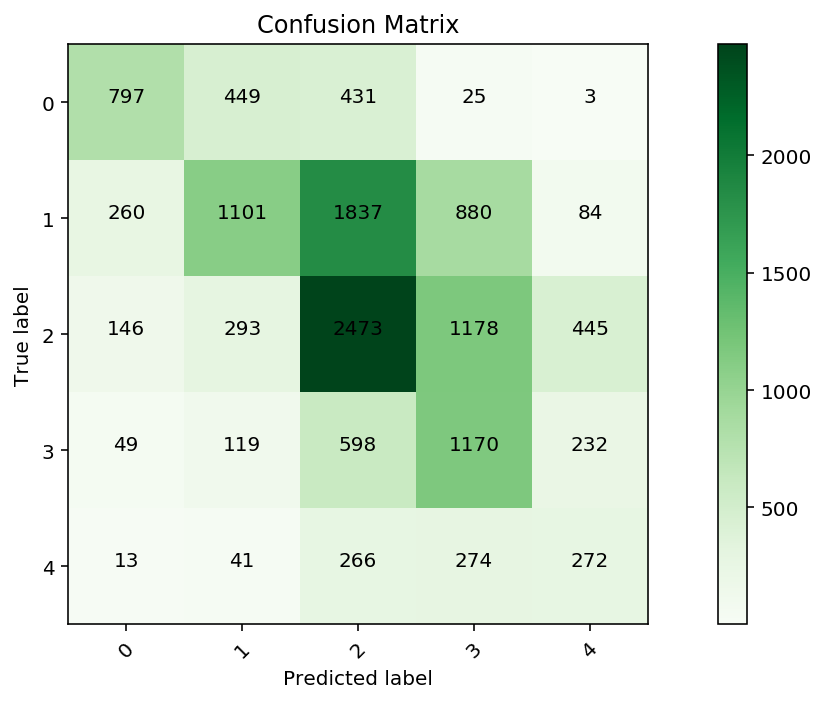

In [25]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= y_results)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

##### 엔드 포인트 삭제

In [26]:
predictor.delete_endpoint()